# Octank IIoT Data Analytics Notebook
Demonstration of [AWS IoT Analytics](https://aws.amazon.com/iot-analytics/) Notebooks, using real-time sensor data.

In [1]:
import boto3
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters

In [2]:
def parse(x):
    return pd.to_datetime(x,
                          infer_datetime_format=True,
                          unit='s',
                          utc=True)

In [3]:
%%time

# use 'nrows=100' for testing
client = boto3.client("iotanalytics")
dataset = "iot_data_dataset"
data_location = client.get_dataset_content(datasetName=dataset)["entries"][0]["dataURI"]
df = pd.read_csv(data_location,
                 header=0,
                 low_memory=False,
                 infer_datetime_format=True,
                 date_parser=parse,
                 index_col=["ts"])

CPU times: user 2.92 s, sys: 321 ms, total: 3.24 s
Wall time: 6.89 s


In [4]:
df = df.drop(columns="__dt")
df = df.sort_values(by="ts", ascending=True)

In [5]:
print(df.head(5))

                                                 device   humidity       temp  \
ts                                                                              
2020-06-20 23:59:32.175828695+00:00  iot-demo-device-01  82.599998  62.060001   
2020-06-20 23:59:34.272635698+00:00  iot-demo-device-02  70.699997  63.139999   
2020-06-20 23:59:34.980094671+00:00  iot-demo-device-03  45.900002  75.919999   
2020-06-20 23:59:40.765217066+00:00  iot-demo-device-03  45.799999  75.919999   
2020-06-20 23:59:45.992712975+00:00  iot-demo-device-01  82.500000  62.060001   

                                     light  motion       lpg        co  \
ts                                                                       
2020-06-20 23:59:32.175828695+00:00   True   False  0.006710  0.004134   
2020-06-20 23:59:34.272635698+00:00   True   False  0.006748  0.004166   
2020-06-20 23:59:34.980094671+00:00   True   False  0.007472  0.004797   
2020-06-20 23:59:40.765217066+00:00   True   False  0.007461  

In [6]:
print("Dataset Range")
print("-------------")
print("Record count: {:,}".format(df["temp"].count()))
print("-------------")
print("Time range (min): {:%Y-%m-%d %H:%M:%S %Z}".format(df.index[1]))
print("Time range (max): {:%Y-%m-%d %H:%M:%S %Z}".format(df.index[-1]))
print("-------------")
print("Records:\n{}".format(df.groupby("device").size()))

Dataset Range
-------------
Record count: 588,247
-------------
Time range (min): 2020-06-20 23:59:34 UTC
Time range (max): 2020-07-07 19:14:58 UTC
-------------
Records:
device
iot-demo-device-01    171550
iot-demo-device-02    166613
iot-demo-device-03    250084
dtype: int64


In [7]:
# filter time range
# df_filtered = df.loc[df.index >= pd.Timestamp('today', tz="UTC").floor('D') + pd.Timedelta(-1, unit='D')]
df_filtered = df.tail(5000)

In [8]:
# filter temp/humidity outliers (>1% & <99%)
df_filtered = df_filtered.loc[df_filtered["temp"] > df_filtered.groupby("device").temp.transform(lambda x: x.quantile(.01))]
df_filtered = df_filtered.loc[df_filtered["temp"] < df_filtered.groupby("device").temp.transform(lambda x: x.quantile(.99))]
df_filtered = df_filtered.loc[df_filtered["humidity"] > df_filtered.groupby("device").humidity.transform(lambda x: x.quantile(.01))]
df_filtered = df_filtered.loc[df_filtered["humidity"] < df_filtered.groupby("device").humidity.transform(lambda x: x.quantile(.99))]

In [9]:
# group by device
# df_filtered = df_filtered.loc[df_filtered['device'] == "iot-demo-device-01"]
groups = df_filtered.groupby("device")

In [10]:
print("Dataset Range")
print("-------------")
print("Filtered record count: {:,}".format(df_filtered["temp"].count()))
print("-------------")
print("Time range (min): {:%Y-%m-%d %H:%M:%S %Z}".format(df_filtered.index[1]))
print("Time range (max): {:%Y-%m-%d %H:%M:%S %Z}".format(df_filtered.index[-1]))
print("Temperature (min): {:.2f}".format(df_filtered["temp"].min()))
print("Temperature (max): {:.2f}".format(df_filtered["temp"].max()))
print("Humidity (min): {:.2f}{}".format(df_filtered["humidity"].min(), "%"))
print("Humidity (max): {:.2f}{}".format(df_filtered["humidity"].max(), "%"))
print("-------------")
print("Record count:\n{}".format(groups.size()))
print("Temperature (min):\n{}".format(groups["temp"].min()))
print("Temperature (max):\n{}".format(groups["temp"].max()))
print("Humidity (min)\n{}".format(groups["humidity"].min()))
print("Humidity (max):\n{}".format(groups["humidity"].max()))

Dataset Range
-------------
Filtered record count: 4,146
-------------
Time range (min): 2020-07-07 16:49:13 UTC
Time range (max): 2020-07-07 19:14:58 UTC
Temperature (min): 64.40
Temperature (max): 89.24
Humidity (min): 44.10%
Humidity (max): 71.20%
-------------
Record count:
device
iot-demo-device-01    1084
iot-demo-device-02    1142
iot-demo-device-03    1920
dtype: int64
Temperature (min):
device
iot-demo-device-01    64.400000
iot-demo-device-02    85.460001
iot-demo-device-03    68.360001
Name: temp, dtype: float64
Temperature (max):
device
iot-demo-device-01    64.760001
iot-demo-device-02    89.239999
iot-demo-device-03    69.439999
Name: temp, dtype: float64
Humidity (min)
device
iot-demo-device-01    69.800003
iot-demo-device-02    44.099998
iot-demo-device-03    49.700001
Name: humidity, dtype: float64
Humidity (max):
device
iot-demo-device-01    71.199997
iot-demo-device-02    54.799999
iot-demo-device-03    53.099998
Name: humidity, dtype: float64


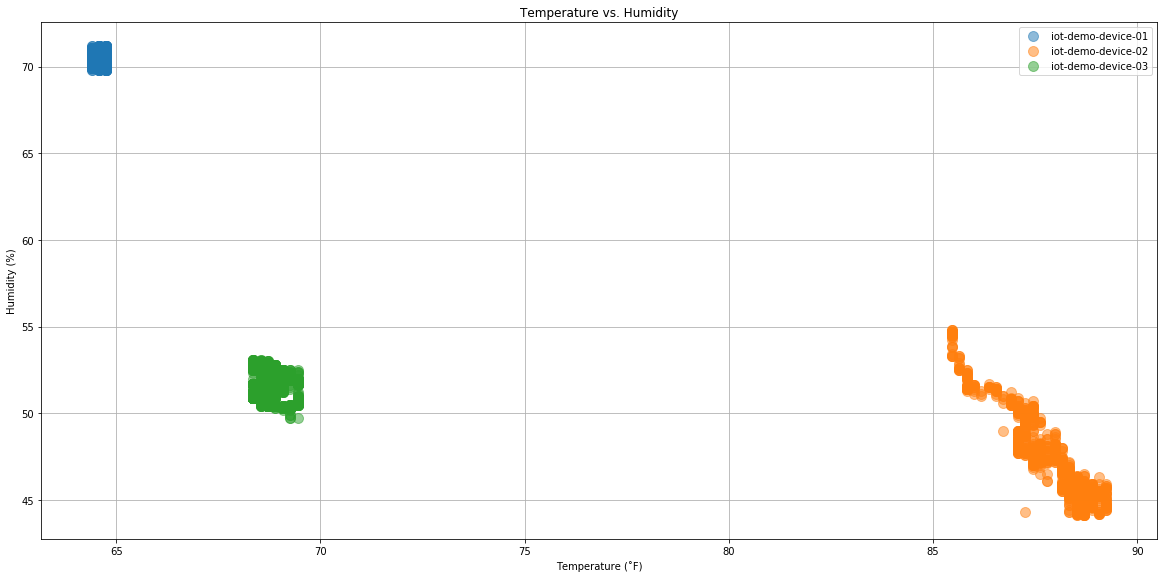

In [11]:
_, ax = plt.subplots(1, 1, figsize=(20, 9.5))
for device, group in groups:
    ax.plot(group.temp,
            group.humidity,
            marker="o",
            linestyle="",
            alpha=.5,
            ms=10,
            label=device)
ax.grid()
ax.margins(0.05)
ax.legend()
plt.title("Temperature vs. Humidity")
plt.xlabel("Temperature (˚F)")
plt.ylabel("Humidity (%)")
plt.show()

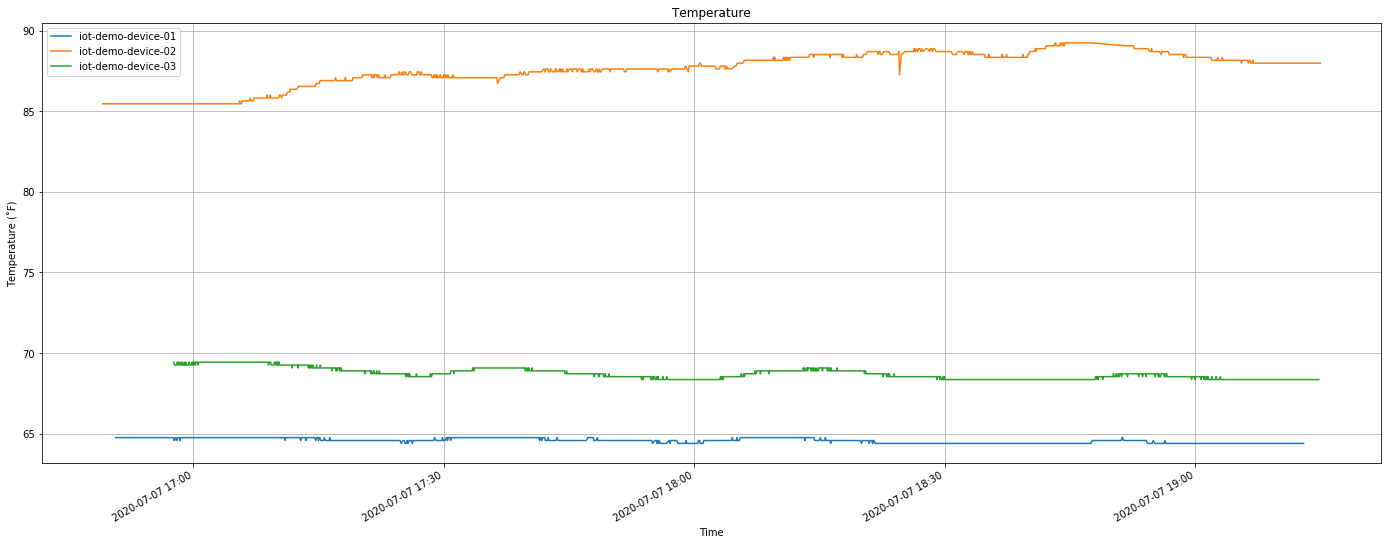

In [12]:
register_matplotlib_converters()
myFmt = DateFormatter("%Y-%m-%d %H:%M")

fig, ax = plt.subplots(1, 1, figsize=(24, 9))
for device, group in groups:
    ax.plot(group.temp,
            label=device)
ax.xaxis.set_major_formatter(myFmt)
fig.autofmt_xdate()
ax.grid()
ax.margins(0.05)
ax.legend()
plt.title("Temperature")
plt.ylabel("Temperature (˚F)")
plt.xlabel("Time")
plt.show()

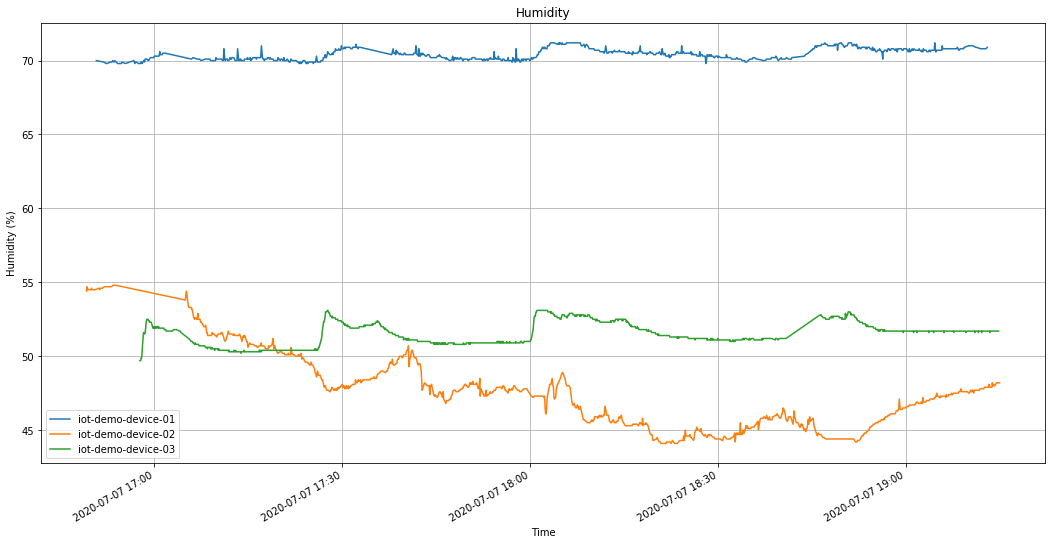

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(18, 9))
for device, group in groups:
    ax.plot(group.humidity,
            label=device)
ax.xaxis.set_major_formatter(myFmt)
fig.autofmt_xdate()
ax.grid()
ax.margins(0.05)
ax.legend()
plt.title("Humidity")
plt.ylabel("Humidity (%)")
plt.xlabel("Time")
plt.show()

In [14]:
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import Category20

output_notebook()

Loading BokehJS ...

In [15]:
p = figure(title="simple line example", x_axis_label='x', y_axis_label='y')

# for device, group in groups:
#     ax.plot(group.humidity,
#             label=device)
# ax.xaxis.set_major_formatter(myFmt)
# fig.autofmt_xdate()
# ax.grid()
# ax.margins(0.05)
# ax.legend()
# plt.title("Humidity")
# plt.ylabel("Humidity (%)")
# plt.xlabel("Time")
# plt.show()

p.scatter(group.temp, group.humidity, line_width=2)

# show the results
show(p, notebook_handle=False)

In [16]:
device01 = df_filtered[df_filtered.device=='iot-demo-device-01']
device02 = df_filtered[df_filtered.device=='iot-demo-device-02']
device03 = df_filtered[df_filtered.device=='iot-demo-device-03']

p = figure(plot_width=900,
           plot_height=300,
           title="Temperature",
           y_axis_type="linear",
           x_axis_type='datetime')

p.multi_line(xs=[device01.index.values, device02.index.values, device03.index.values], 
             ys=[device01['temp'], device02['temp'], device03['temp']],
             color=['red', 'green', 'blue'])

show(p, notebook_handle=False)

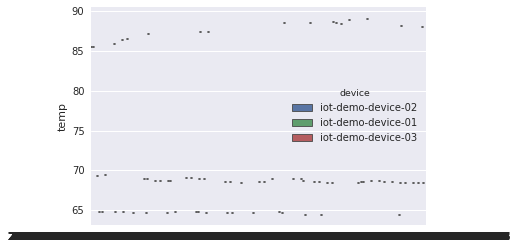

In [17]:
import seaborn as sns
sns.set(style="darkgrid")

# Plot the responses for different events and regions
sns.lvplot(x=df_filtered.index.values,
           y="temp",
           hue="device",
           data=df_filtered)